<a href="https://colab.research.google.com/github/TheKidKy/brain_tumor_detection/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.transforms import v2
from torchvision import datasets, models, transforms
from torchvision.models import ResNet50_Weights, ResNet101_Weights
from torchvision.transforms import ToTensor
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import numpy as np
import os
import copy
import time
from tqdm import tqdm
import cv2 as cv
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check if a GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Loading Data

In [ ]:
# --- Paths ---
folder = '/content/drive/MyDrive/Brain_Tumor'
training_directory = os.path.join(folder, 'Training')
testing_directory = os.path.join(folder, 'Testing')

# --- Load train data ---
xtrain, ytrain = [], []

try:
    for class_name in os.listdir(training_directory):
        class_path = os.path.join(training_directory, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                img = cv.imread(img_path, 0)  # grayscale
                if img is not None:
                    xtrain.append(img)
                    ytrain.append(class_name)
except (KeyboardInterrupt, Exception) as e:
    print(f"Error: {e}")

train_df = pd.DataFrame({"IMAGE": xtrain, "RESULT": ytrain})
print(train_df.tail())



# --- Load test data ---
xtest, ytest = [], []
try:
    for class_name in os.listdir(testing_directory):
        class_path = os.path.join(testing_directory, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                img = cv.imread(img_path, 0)
                if img is not None:
                    xtest.append(img)
                    ytest.append(class_name)
except (KeyboardInterrupt, Exception) as e:
    print(f"Error: {e}")


test_df = pd.DataFrame({"IMAGE": xtest, "RESULT": ytest})
print(test_df.tail())

                                                   IMAGE        RESULT
11693  [[0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 1, 3, 3,...  glioma_tumor
11694  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  glioma_tumor
11695  [[0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,...  glioma_tumor
11696  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  glioma_tumor
11697  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  glioma_tumor
                                                  IMAGE        RESULT
1581  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  glioma_tumor
1582  [[0, 2, 4, 1, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0,...  glioma_tumor
1583  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  glioma_tumor
1584  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  glioma_tumor
1585  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  glioma_tumor


In [ ]:
label_map = {'no_tumor': 0, 'glioma_tumor': 1, 'meningioma_tumor': 2, 'pituitary_tumor': 3}

In [ ]:
from PIL import Image

class TumorDataset(Dataset):
    def __init__(self, df, transform=None):
        self.images = df['IMAGE'].values
        self.labels = df['RESULT'].values
        self.transform = transform

        classes = sorted(df['RESULT'].unique())
        self.label_map = {c: i for i, c in enumerate(classes)}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # NumPy array, shape (H,W)

        # --- Ensure conversion from NumPy array to PIL Image ---
        img = Image.fromarray(img)  # convert to PIL Image

        if self.transform:
            img = self.transform(img)  # apply transforms (Resize, Grayscale, ToTensor, Normalize)

        label = self.label_map[self.labels[idx]]
        label = torch.tensor(label, dtype=torch.long)
        return img, label

### Transform To Tensors

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
# --- Split train/val ---
train_subset_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['RESULT'], random_state=42)

# --- Create datasets ---
train_dataset = TumorDataset(train_subset_df, transform=train_transform)
val_dataset = TumorDataset(val_df, transform=train_transform)
test_dataset = TumorDataset(test_df, transform=test_transform)

# --- Create dataloaders ---
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

### Initializing ResNet50 Model

In [ ]:
def create_resnet50_model(num_classes=4):
    """
    Create ResNet50 model with pretrained ImageNet weights
    """
    # Load pretrained ResNet50
    model = models.resnet50(ResNet50_Weights.IMAGENET1K_V2)

    # Freeze some layers initially
    for param in model.layer3.parameters():
        param.requires_grad = False
    for param in model.layer2.parameters():
        param.requires_grad = False
    for param in model.layer1.parameters():
        param.requires_grad = False


    # Replace the final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )

    return model

# Create model
model = create_resnet50_model(num_classes=4)
# print(model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


### Training Model

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Only optimize the final layers (unfreeze some layers if needed)
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': 0.0001},
    {'params': model.layer4.parameters(), 'lr': 0.0001},
    {'params': model.layer2.parameters(), 'lr': 0.00002},
    {'params': model.layer1.parameters(), 'lr': 0.00002}, # Lower learning rate for earlier layers

])


# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

Using device: cuda


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    """
    Train the model with early stopping
    """
    best_acc = -float('inf')  # Initialize to negative infinity for first comparison
    patience_counter = 0  # Counter for early stopping
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])

            # Store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save best model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')
                patience_counter = 0  # Reset patience if we have improved
            elif phase == 'test' and epoch_acc <= best_acc:
                patience_counter += 1

        # Early stopping condition
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch}')
            break

        print()

    print(f'Best val Acc: {best_acc:.4f}')
    return model, history

### Training Execution

In [ ]:
num_epochs = 25
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs)

Epoch 0/24
----------


100%|██████████| 293/293 [00:18<00:00, 15.58it/s]


train Loss: 0.4305 Acc: 0.8319


100%|██████████| 50/50 [00:01<00:00, 25.24it/s]


test Loss: 1.0019 Acc: 0.7377

Epoch 1/24
----------


100%|██████████| 293/293 [00:18<00:00, 15.79it/s]


train Loss: 0.0841 Acc: 0.9702


100%|██████████| 50/50 [00:02<00:00, 24.14it/s]


test Loss: 1.0612 Acc: 0.7799

Epoch 2/24
----------


100%|██████████| 293/293 [00:18<00:00, 15.54it/s]


train Loss: 0.0313 Acc: 0.9901


100%|██████████| 50/50 [00:02<00:00, 24.94it/s]


test Loss: 1.4314 Acc: 0.7541

Epoch 3/24
----------


100%|██████████| 293/293 [00:18<00:00, 15.64it/s]


train Loss: 0.0271 Acc: 0.9923


100%|██████████| 50/50 [00:02<00:00, 24.62it/s]


test Loss: 1.5227 Acc: 0.7472

Epoch 4/24
----------


100%|██████████| 293/293 [00:19<00:00, 15.26it/s]


train Loss: 0.0193 Acc: 0.9939


100%|██████████| 50/50 [00:02<00:00, 24.61it/s]


test Loss: 1.0845 Acc: 0.8001

Epoch 5/24
----------


100%|██████████| 293/293 [00:18<00:00, 15.59it/s]


train Loss: 0.0068 Acc: 0.9979


100%|██████████| 50/50 [00:02<00:00, 24.50it/s]


test Loss: 1.5379 Acc: 0.7654

Epoch 6/24
----------


100%|██████████| 293/293 [00:18<00:00, 15.49it/s]


train Loss: 0.0055 Acc: 0.9986


100%|██████████| 50/50 [00:02<00:00, 24.55it/s]


test Loss: 1.4281 Acc: 0.7718

Epoch 7/24
----------


 46%|████▌     | 134/293 [00:08<00:10, 15.41it/s]


KeyboardInterrupt: 

<Figure size 800x600 with 0 Axes>

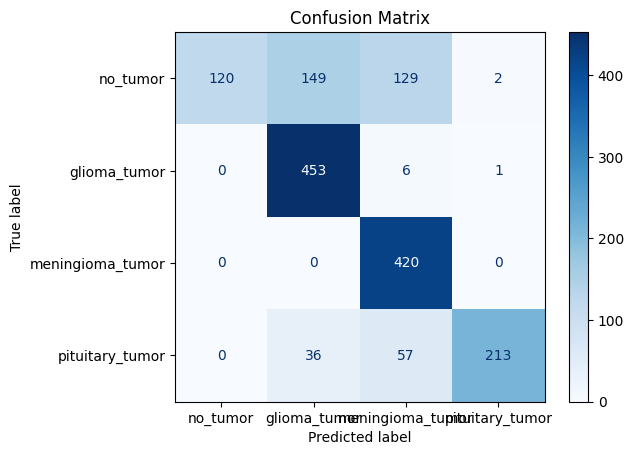

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Put model in evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloaders['test']:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Build confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor'])

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()